# 1) Imports + helper functions

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq


# 2) Pick ticker, download history and available expiries

In [ ]:
ticker_symbol = "AAPL"     # students can change
t = yf.Ticker(ticker_symbol)

# historical price
hist = t.history(period="1y")   # 1 year; or use start="2024-01-01", end="2025-09-01"
hist.reset_index(inplace=True)

# list option expirations
expiries = t.options
print("Available expirations:", expiries[:6])


Available expirations: ('2025-09-19', '2025-09-26', '2025-10-03', '2025-10-10', '2025-10-17', '2025-10-24')


# 3) Pull one expiry’s option chain and save CSVs

In [ ]:
expiry = expiries[0]   # choose the first expiry (or let the student pick)
chain = t.option_chain(expiry)
calls = chain.calls.copy()
puts = chain.puts.copy()

# quick clean / ensure numeric cols
for df in (calls, puts):
    df['openInterest'] = pd.to_numeric(df['openInterest'], errors='coerce').fillna(0)
    df['strike'] = pd.to_numeric(df['strike'], errors='coerce')

# save for sharing / Excel
calls.to_csv(f"{ticker_symbol}_calls_{expiry}.csv", index=False)
puts.to_csv(f"{ticker_symbol}_puts_{expiry}.csv", index=False)


# 4) Simple metrics (put/call ratio, top OI strikes)
Put/Call Ratio (OCR):
*   If > 1 → more puts than calls (bearish).
*  If < 1 → more calls than puts (bullish).
Finds top 5 strikes with most interest (where big traders are focused).




In [ ]:
ocr = (puts['openInterest'].sum() / calls['openInterest'].sum()) if calls['openInterest'].sum() else np.nan
print("Put / Call ratio (by open interest):", round(ocr, 3))

top_calls = calls.sort_values('openInterest', ascending=False).head(5)[['strike','openInterest','lastPrice','impliedVolatility']]
top_puts  = puts.sort_values('openInterest', ascending=False).head(5)[['strike','openInterest','lastPrice','impliedVolatility']]

display(top_calls, top_puts)


Put / Call ratio (by open interest): 0.69


,strike,openInterest,lastPrice,impliedVolatility
54,240.0,57724,0.95,0.250496
50,230.0,53817,5.60,0.270759
56,245.0,48209,0.32,0.261238
58,250.0,43034,0.12,0.282722
52,235.0,39662,2.59,0.254402


,strike,openInterest,lastPrice,impliedVolatility
39,200.0,35193,0.04,0.503911
38,195.0,25124,0.02,0.554692
32,165.0,22613,0.01,0.921876
35,180.0,22182,0.01,0.734378
46,220.0,20840,0.20,0.300788


# 5) Max-pain (easy algorithm)
(Explanation for students: “max pain” is the stock price where total option-holder losses are minimized — useful as a simple indicator of where large OI sits.)

In [ ]:
def compute_max_pain(calls_df, puts_df):
    strikes = sorted(set(calls_df['strike']).union(puts_df['strike']))
    pains = []
    for s in strikes:
        calls_loss = ((np.maximum(s - calls_df['strike'], 0)) * calls_df['openInterest']).sum()
        puts_loss = ((np.maximum(puts_df['strike'] - s, 0)) * puts_df['openInterest']).sum()
        pains.append((s, calls_loss + puts_loss))
    pain_df = pd.DataFrame(pains, columns=['strike','pain']).sort_values('pain')
    max_pain_strike = pain_df.iloc[0]['strike']
    return max_pain_strike, pain_df

max_pain_strike, pain_df = compute_max_pain(calls, puts)
print("Max pain strike:", max_pain_strike)


Max pain strike: 217.5


# 6) Plot IV (implied volatility) vs strike
(Students learn how IV varies by strike: often U-shaped — “smile” or “skew”.)
Shows how expensive options are at different strikes.

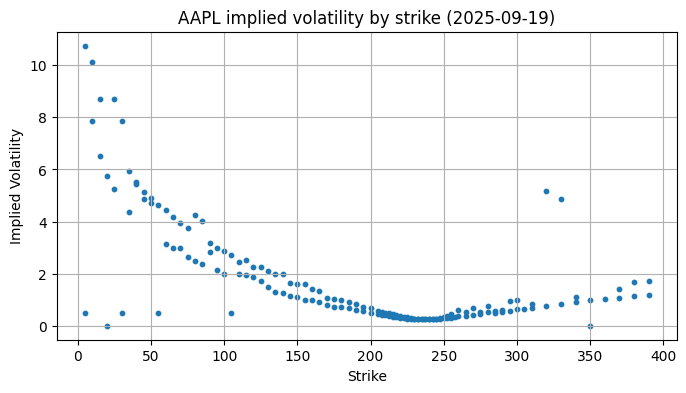

In [ ]:
import matplotlib.pyplot as plt

# combine for IV surface at this expiry
iv = pd.concat([
    calls[['strike','impliedVolatility']].assign(type='call'),
    puts[['strike','impliedVolatility']].assign(type='put')
]).dropna()

plt.figure(figsize=(8,4))
plt.scatter(iv['strike'], iv['impliedVolatility'], s=10)
plt.title(f"{ticker_symbol} implied volatility by strike ({expiry})")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()


# 7) Optional: Black-Scholes call pricer + simple implied vol solver

In [ ]:
def bs_call_price(S,K,T,r,sigma):
    if T <= 0 or sigma <= 0:
        return max(S-K,0)
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_vol_call(market_price, S, K, T, r=0.0):
    # solve bs_call_price(sigma) = market_price
    f = lambda sigma: bs_call_price(S,K,T,r,sigma) - market_price
    try:
        return brentq(f, 1e-6, 5.0)   # bracket [1e-6, 5]
    except ValueError:
        return np.nan
